# 💻 Project 2 [Laptops]
### Data Collection + Data Cleansing/Preprocessing + Exploratory Data Analysis [EDA]
https://www.kaggle.com/code/h4nzarick/project-2-laptop-configuration
<hr>
Buying a laptop is a decision almost all of us have made at some time. Each of us tries to have the best equipment at the lowest possible price, but it is known that more expensive components make the price of the equipment increase. But which component affects the price the most? Using website of local KZ electronics ("Belyi Veter") we collected data from its database using asynchronuous web scrapping, and try to work with "real-world" dataset consisting of missing values, duplicates, and outliers to answer our business question.

<p>


Our final result will be top 15 factors affecting price of laptops and cleansed dataset, and to show it interactively we will create Streamlit web application for configurize laptops and make an assessment test with recommendational system. 
    
To collect data, BeautifulSoup was used (later I realized that using Scrapy would be much more efficient in terms of time and performance)
To analyze data, necessary Python libraries were handled, specifically
* pandas, numpy - data **manipulation** (missing values handling, duplicates, outlier detection)
* seaborn, matplotlib, plotly - data **visualization**
* scipy - **statistical** estimations
    
The main and unsolved challenge is handling price feature: sometimes website owners do not update prices of products, and as a result scraper cannot collect info about it. Several methods were tried, but none of them could provide quality solution.
* Train regression model to predict missing prices on very small set of data entries (result: overfitting with trained data) - imbalancy between seen and unseen splits
* Overwrite NaNs with mode, median, or mean values for grouped laptops by brand name, cpu, gpu - outliers due to the imbalancy between splits as well
* Fill NaN with prompts to OpenAI API (most efficient, but unreliable in terms of data), so I decided to skip that step 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/laptops.csv")
df.head()

,laptop id,title,old price,current price,Операционная система,Процессор,Интегрированная в процессор графика,"Объем оперативной памяти, ГБ",Жесткий диск,Твердотельный накопитель,...,Разрешение экрана,"Вес, кг",image link,Внимание,Модель процессора,"Частота процессора, ГГц",Конфигурация оперативной памяти,Модель дискретной видеокарты,USB Type-C Power Delivery,Вес
0,179950,Apple MacBook Air A3114 с дисплеем Retina Liquid,849 990 ₸,829 990 ₸,Mac OS Ventura,Apple M3,10 Core GPU,8,HDD нет,256 ГБ SSD,...,2880 x 1864,1.51,//static.shop.kz/upload/iblock/0d2/0qi447tpcq9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,179949,Apple MacBook Air A3113 с дисплеем Retina Liquid,849 990 ₸,829 990 ₸,Mac OS Ventura,Apple M3,8 Core GPU,8,HDD нет,512 ГБ SSD,...,2560 x 1664,1.24,//static.shop.kz/upload/iblock/93a/0v6ygrdzart...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179947,Apple MacBook Air A3113 с дисплеем Retina Liquid,849 990 ₸,829 990 ₸,Mac OS Ventura,Apple M3,8 Core GPU,8,HDD нет,512 ГБ SSD,...,2560 x 1664,1.24,//static.shop.kz/upload/iblock/ba9/pi969xxwe6k...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,179912,HP ProBook 450 G10,524 990 ₸,499 990 ₸,Отсутствует,Intel Core i7,Intel UHD Graphics,16,HDD нет,512 ГБ SSD,...,1920 x 1080 Full HD,1.79,//static.shop.kz/upload/iblock/419/z7io8p3g1ty...,Не забудьте купитьоперационную систему,1355U,1.7,1 х 16 ГБ,NaN,NaN,NaN
4,179913,HP ProBook 450 G10,749 990 ₸,719 990 ₸,Windows 11 Pro (x64),Intel Core i7,Intel UHD Graphics,16,HDD нет,1 ТБ SSD,...,1920 x 1080 Full HD,1.79,//static.shop.kz/upload/iblock/ed4/i3xjxdwlh7v...,NaN,1355U,1.7,1 х 16 ГБ,GeForce RTX 2050,NaN,NaN


In [3]:
# Column renaming
df.rename(columns={
    "Операционная система": "Operational system",
    "Процессор": "CPU",
    "Интегрированная в процессор графика": "Integrated graphics",
    "Объем оперативной памяти, ГБ": "RAM",
    "Жесткий диск": "HDD",
    "Твердотельный накопитель": "SSD",
    "Диагональ экрана, дюйм": "Display Diagonal",
    "Разрешение экрана": "Screen resolution",
    "Вес, кг": "Weight",
    "Внимание": "Warning",
    "Модель процессора": "CPU model",
    "Частота процессора, ГГц": "CPU frequency",
    "Конфигурация оперативной памяти": "RAM Configuration",
    "Модель дискретной видеокарты": "GPU",
    "Вес": "Weight_1"
}, inplace=True)

df.columns = [column.replace(" ", "_").lower() for column in df.columns]
df.drop(["cpu_model", "ram_configuration"], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   laptop_id                  2368 non-null   object 
 1   title                      2368 non-null   object 
 2   old_price                  587 non-null    object 
 3   current_price              587 non-null    object 
 4   operational_system         2368 non-null   object 
 5   cpu                        2368 non-null   object 
 6   integrated_graphics        2356 non-null   object 
 7   ram                        2368 non-null   int64  
 8   hdd                        2350 non-null   object 
 9   ssd                        2359 non-null   object 
 10  display_diagonal           2368 non-null   float64
 11  screen_resolution          2367 non-null   object 
 12  weight                     2018 non-null   float64
 13  image_link                 2368 non-null   objec

Dataframe consists of 2368 rows and 21 variables. Each row corresponds to one laptop and variables describe its main components such as CPU/GPU,RAM configuration, Memory capacity, operation system, etc. 

Data does contain plenty of NaN values due to the scrapper issues, so it is required to cleanse, organize, and prepare data for further exploration.

In [5]:
# Before starting, let's save image links into another dataframe (csv) for further purposes
image_links =  df[["laptop_id", "image_link"]].copy()
df.drop("image_link", axis=1, inplace=True)

### 1. Data Organizing
<hr>
In this section, we will perform data cleansing of duplicates and missing values. Several handling null values techniques exist, we will choose the most common one: filling such gaps with measures of central tendency

In [6]:
# Duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


There is no duplicates at all, so we can process to further steps immediately

#### Null Values
<hr>
Handling missing values is an essential part of data cleaning and preparation process because almost all data in real life comes with some missing values.

In [7]:
# Missing values proportion
print("Missing value proportion by column")
for column in df.columns:
    print(f"{column}: {np.round(df[column].isnull().mean() * 100, 2)}%")

Missing value proportion by column
laptop_id: 0.0%
title: 0.0%
old_price: 75.21%
current_price: 75.21%
operational_system: 0.0%
cpu: 0.0%
integrated_graphics: 0.51%
ram: 0.0%
hdd: 0.76%
ssd: 0.38%
display_diagonal: 0.0%
screen_resolution: 0.04%
weight: 14.78%
cpu_frequency: 3.59%
gpu: 56.42%
usb_type-c_power_delivery: 59.8%
weight_1: 85.18%


The picture is not so frightening, some variables miss values, but not big proportion, the only **exception** are price columns, the underlying reason was provided above.

Let's handle each column one by one to make things clear.

##### GPU (Integrated Graphics only)
The only case when laptop does not have any graphic chipset in our dataset, but it cannot be really a real world case, so we can assume that this is an office laptop having integrated graphics

In [8]:
no_both_graphics_index = df[(df["integrated_graphics"].isna()) & (df["gpu"].isna())].index
df.loc[no_both_graphics_index, "integrated_graphics"] = df["integrated_graphics"].mode()[0]  # take the most occurred graphic

# if laptop has only GPU, there is not any integrated graphic chipset in CPU, so "No" instead of NaN
df.loc[df[(df["integrated_graphics"].isna()) & (df["gpu"].notna())].index, "integrated_graphics"] = "No" 

##### HDD | SSD 
HDD is the similar case with graphics, laptops can have either both of them (SSD + HDD) or only one of them.

In [9]:
missing_hdds = df[df['hdd'].isna()]

print(f"Number of laptops with missing HDDs: {missing_hdds.shape[0]}")
print(f"Number of laptops with missing HDDs but with SSDs: {missing_hdds[~missing_hdds['ssd'].isna()].shape[0]}")

df.loc[missing_hdds.index, "hdd"] = "No" # to replace NaN
print(f"Number of NaN HDDs: {df['hdd'].isna().sum()}")

Number of laptops with missing HDDs: 18
Number of laptops with missing HDDs but with SSDs: 18
Number of NaN HDDs: 0


In [10]:
missing_ssds = df[df['ssd'].isna()]

print(f"Number of laptops with missing SSDs: {missing_ssds.shape[0]}")
print(f"Number of laptops with missing SSDs but with HDDs: {missing_ssds[~missing_ssds['hdd'].isna()].shape[0]}")

df.loc[missing_ssds.index, "ssd"] = "No"
print(f"Number of NaN SDDs: {df['ssd'].isna().sum()}")


Number of laptops with missing SSDs: 9
Number of laptops with missing SSDs but with HDDs: 9
Number of NaN SDDs: 0


In both cases, we can see that when HDD is missing, laptop contains SSD and vice versa. At this standpoint, we can simple overwrite null values with "No", which can be preprocessed on feature engineering step

##### Screen Resolution

In [11]:
missing_resolution = df[df["screen_resolution"].isna()]
missing_resolution

,laptop_id,title,old_price,current_price,operational_system,cpu,integrated_graphics,ram,hdd,ssd,display_diagonal,screen_resolution,weight,warning,cpu_frequency,gpu,usb_type-c_power_delivery,weight_1
1651,149450,ASUS VivoBook X512DA,NaN,NaN,Отсутствует,AMD Ryzen 3,AMD Radeon Vega 3,8,HDD нет,256 ГБ SSD,15.6,NaN,1.65,Не забудьте купитьоперационную систему,2.6,NaN,NaN,NaN


Only one of the ASUS VivoBooks does miss screen resolution variable, we can overwrite it with the most occured resolution among ASUS VivoBooks.

In [12]:
 # ASUS VivoBook is pretty popular ultrabook, and we can replace NaN with the most common one across all vivobooks laptops
vivo_screen_resolution = df[df["title"].str.contains("VivoBook")]["screen_resolution"].mode()[0]
df.loc[missing_resolution.index, "screen_resolution"] = vivo_screen_resolution

print(f"Number of missing resolutions: {df['screen_resolution'].isna().sum()}")

Number of missing resolutions: 0


##### Weight

In [13]:
missing_weight = df[df["weight"].isna()]

print(f"Number of missing weights: {missing_weight.shape[0]}")
print(f"Number of missing weights with non NaN value in weight_1 column: {missing_weight[missing_weight['weight_1'].notna()].shape[0]}")

missing_weight.head()

Number of missing weights: 350
Number of missing weights with non NaN value in weight_1 column: 348


,laptop_id,title,old_price,current_price,operational_system,cpu,integrated_graphics,ram,hdd,ssd,display_diagonal,screen_resolution,weight,warning,cpu_frequency,gpu,usb_type-c_power_delivery,weight_1
968,138282+PF1NJSLP,Lenovo Ideapad 330 (81DE02S6RK),NaN,NaN,Windows 10 Home (x64),Intel Core i3,Intel UHD Graphics 620,4,1 ТБ HDD,SSD нет,15.6,1366 x 768 HD,NaN,NaN,2.2,NaN,NaN,1.9 кг
1316,157214,ASUS TUF Gaming FX706HM,NaN,NaN,Отсутствует,Intel Core i5,Intel UHD Graphics,16,HDD нет,512 ГБ SSD,17.3,1920 x 1080 Full HD,NaN,Не забудьте купитьоперационную систему,2.7,GeForce RTX 3060,NaN,2.6
1472,154075,HP ENVY x360 13-ay0040ur,NaN,NaN,Windows 10 Home (x64),AMD Ryzen 3,AMD Radeon Graphics,8,HDD нет,512 ГБ SSD,13.3,1920 x 1080 Full HD,NaN,NaN,2.7,NaN,NaN,1.3
1557,151798,Acer Nitro 5 AN517-52,NaN,NaN,Отсутствует,Intel Core i5,Intel UHD Graphics,8,HDD нет,512 ГБ SSD,17.3,1920 x 1080 Full HD,NaN,Не забудьте купитьоперационную систему,2.5,GeForce GTX 1650 Ti,NaN,2.7
1558,151796,Acer Nitro 5 AN517-52,NaN,NaN,Отсутствует,Intel Core i5,Intel UHD Graphics,16,HDD нет,512 ГБ SSD,17.3,1920 x 1080 Full HD,NaN,Не забудьте купитьоперационную систему,2.5,GeForce GTX 1660 Ti,NaN,2.7


Two columns of weight variable were occured as a result of scrapping, and it seems that almost all weights could be overwritten with those from weight_1 column, only 2 weights will be missed

In [14]:
# 
def clean_weight(weight):
    if pd.isna(weight):
        return weight
    try:
        value = np.float64(weight.split()[0])
        if value < 4:  # To handle potential outliers (laptops)
            return value
    except (ValueError, AttributeError):
        pass
    return np.nan

df["weight_1"] = df["weight_1"].apply(clean_weight)

Convert dtype of weight attribute to float64 for overwriting purposes

In [15]:
df.loc[missing_weight.index, "weight"] = missing_weight["weight_1"]
remaining_missing_weights = df[df["weight"].isna()]
remaining_missing_weights

,laptop_id,title,old_price,current_price,operational_system,cpu,integrated_graphics,ram,hdd,ssd,display_diagonal,screen_resolution,weight,warning,cpu_frequency,gpu,usb_type-c_power_delivery,weight_1
2150,139358,Apple MacBook Pro с дисплеем Retina,NaN,NaN,Mac OS Mojave,Intel Core i7,Intel UHD Graphics 630,16,HDD нет,256 ГБ SSD,15.4,2880 x 1800 WQ+,NaN,NaN,2.6,Radeon Pro 555X,NaN,NaN
2151,139465,Apple MacBook Pro с дисплеем Retina,NaN,NaN,Mac OS Mojave,Intel Core i5,Intel Iris Plus Graphics 655,8,HDD нет,256 ГБ SSD,13.3,2560 x 1600 WQXGA,NaN,NaN,2.4,NaN,NaN,NaN


Only 2 MacBooks remain with missing weight

Macbook Pros are almost similar in terms of weight, so we can overwrite null values with mode of the weight among those laptops

In [16]:
df.loc[remaining_missing_weights.index, "weight"] = df[df["title"].str.contains("Apple MacBook Pro")]["weight"].mode()[0]

print(f"Number of missing weights: {df['weight'].isna().sum()}")

Number of missing weights: 0


In [17]:
# Deleting weight_1 column (no further needs)
df.drop("weight_1", axis=1, inplace=True)

In [18]:
# Warning column
df["warning"].value_counts()

# No need in that column, just delete it
df.drop("warning", axis=1, inplace=True)

In [19]:
print("Missing value proportion by column")
for column in df.columns:
    print(f"{column}: {np.round(df[column].isnull().mean() * 100, 2)}%")

Missing value proportion by column
laptop_id: 0.0%
title: 0.0%
old_price: 75.21%
current_price: 75.21%
operational_system: 0.0%
cpu: 0.0%
integrated_graphics: 0.0%
ram: 0.0%
hdd: 0.0%
ssd: 0.0%
display_diagonal: 0.0%
screen_resolution: 0.0%
weight: 0.0%
cpu_frequency: 3.59%
gpu: 56.42%
usb_type-c_power_delivery: 59.8%


We almost done with missing values, only CPU frequancy and gpu are left

##### CPU Frequency

In [20]:
# CPU frequency
missing_freqs = df[df["cpu_frequency"].isna()]
missing_freqs["title"].value_counts()

title
Apple MacBook Air A2337 с дисплеем Retina               14
Apple MacBook Air A2681 с дисплеем Retina Liquid        12
Apple MacBook Pro A2338 с дисплеем Retina                9
Apple MacBook Pro A2991 с дисплеем Retina Liquid XDR     8
Apple MacBook Air A2941 с дисплеем Retina Liquid         8
Apple MacBook Air A3114 с дисплеем Retina Liquid         6
Apple MacBook Air A3113 с дисплеем Retina Liquid         6
Apple MacBook Pro A2992 с дисплеем Retina Liquid XDR     6
Apple MacBook Pro A2780 с дисплеем Retina Liquid XDR     5
Apple MacBook Pro A2918 с дисплеем Retina Liquid XDR     4
Apple MacBook Pro A2485 с дисплеем Retina Liquid XDR     2
Apple MacBook Pro A2779 с дисплеем Retina Liquid XDR     2
Apple MacBook Pro A2442 с дисплеем Retina                2
HP ENVY x360 13-bf0026ci, OLED                           1
Name: count, dtype: int64

For our convinience, we extracted title of laptops with missing cpu frequencya and most of them are either Macbook Air or Pro

Let's preprocess them as was shown in previous steps

In [21]:
# Macbooks without missing cpu frequencies
macbooks_w_freq = df[(df["title"].str.contains("Apple")) & (df["cpu_frequency"].notna())]

# Let's take two modes from the dataset, one belongs to CPU frequency of Macbook Pros and another one is for Macbook Air
freq_air = macbooks_w_freq[macbooks_w_freq["title"].str.contains("Air")]["cpu_frequency"].mode()[0]
freq_pro = macbooks_w_freq[macbooks_w_freq["title"].str.contains("Pro")]["cpu_frequency"].mode()[0]

# Overwrite missing frequency with those one
df.loc[missing_freqs["title"].str.contains("Air").index, "cpu_frequency"] = freq_air
df.loc[missing_freqs["title"].str.contains("Pro").index, "cpu_frequency"] = freq_pro

df[df["cpu_frequency"].isna()]

,laptop_id,title,old_price,current_price,operational_system,cpu,integrated_graphics,ram,hdd,ssd,display_diagonal,screen_resolution,weight,cpu_frequency,gpu,usb_type-c_power_delivery


##### Discrete Graphics (GPU)

In [22]:
gpu_missing = df[df["gpu"].isna()]
print(f"Number of GPU missing: {gpu_missing.shape[0]}")
print(f"Number of GPU missing with integrated graphics: {gpu_missing[gpu_missing['integrated_graphics'].notna()].shape[0]}")

Number of GPU missing: 1336
Number of GPU missing with integrated graphics: 1336


Laptops without GPUs contain integrated graphics, so leave "No" in place of NaN

In [23]:
df.loc[gpu_missing.index, "gpu"] = "No"
print(f"Number of GPU missing: {df['gpu'].isna().sum()}")

Number of GPU missing: 0


In [24]:
# missing type-c power delivery is just a case of its lackness
df.loc[df[df['usb_type-c_power_delivery'].isna()].index, 'usb_type-c_power_delivery'] = "No"

In [25]:
print("Missing value proportion by column")
for column in df.columns:
    print(f"{column}: {np.round(df[column].isnull().mean() * 100, 2)}%")

Missing value proportion by column
laptop_id: 0.0%
title: 0.0%
old_price: 75.21%
current_price: 75.21%
operational_system: 0.0%
cpu: 0.0%
integrated_graphics: 0.0%
ram: 0.0%
hdd: 0.0%
ssd: 0.0%
display_diagonal: 0.0%
screen_resolution: 0.0%
weight: 0.0%
cpu_frequency: 0.0%
gpu: 0.0%
usb_type-c_power_delivery: 0.0%


We are done with cleansing step, so let's move to another Data Organizign Step

#### Feature Engineering
<hr>
Even though we got rid of missing values from the dataframe, it is still too messy to go further (i.e. double language problem, too many categories for categorical variables, etc.)


My idea is to examine each column separately, and after completing all of them, I can move further 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   laptop_id                  2368 non-null   object 
 1   title                      2368 non-null   object 
 2   old_price                  587 non-null    object 
 3   current_price              587 non-null    object 
 4   operational_system         2368 non-null   object 
 5   cpu                        2368 non-null   object 
 6   integrated_graphics        2368 non-null   object 
 7   ram                        2368 non-null   int64  
 8   hdd                        2368 non-null   object 
 9   ssd                        2368 non-null   object 
 10  display_diagonal           2368 non-null   float64
 11  screen_resolution          2368 non-null   object 
 12  weight                     2368 non-null   object 
 13  cpu_frequency              2368 non-null   float

#### Laptop Title
The column can provide us with the brand of the laptop and get rid of the russian words from it

In [27]:
df["brand"] = df["title"].apply(lambda title: title.split()[0])
df["model"] = df["title"].apply(lambda title: " ".join(title.split()[1:]))
df["model"] = df["model"].str.replace("с дисплеем", "with display")

#### Laptop Price
Manipulation with dtype

In [28]:
# Convert both price columns into float64 by removing currency symbol and spaces between numbers
df["old_price"] = df["old_price"].apply(lambda price: np.float64(int(''.join(price.split()[:-1]))) if not pd.isna(price) else np.nan)
df["current_price"] = df["current_price"].apply(lambda price: np.float64(int(''.join(price.split()[:-1]))) if not pd.isna(price) else np.nan)

Sometimes shop makes discount on products, so let's calculate it

In [29]:
df["discount_rate_percent"] = np.round((df["old_price"] - df["current_price"]) / df["old_price"] * 100, 2)

#### Operational System

In [30]:
df["operational_system"].value_counts()

operational_system
Отсутствует                         1057
Windows 10 Home (x64)                312
Windows 11 Home (x64)                214
Windows 11 Pro (x64)                 170
Windows 10 Pro (x64)                 147
Linux                                132
Windows 11 Home (x64) SL             115
Windows 10 Home (x64) SL              83
Mac OS Ventura                        29
Mac OS Mojave                         27
Mac OS Monterey                       23
Mac OS                                22
Mac OS Big Sur                        10
Mac OS Catalina                        8
Windows 10 Home (x64) в S-режиме       6
Windows 10 Home S                      4
Windows 10 / Windows 11                3
Mac OS X Big Sur                       2
Mac OS Sierra                          2
Windows 8 (x64)                        1
Mac OS X                               1
Name: count, dtype: int64

In [31]:
df.loc[df[df["operational_system"] == "Отсутствует"].index, "operational_system"] = "DOS"

In [32]:
df["operational_system"].value_counts()

operational_system
DOS                                 1057
Windows 10 Home (x64)                312
Windows 11 Home (x64)                214
Windows 11 Pro (x64)                 170
Windows 10 Pro (x64)                 147
Linux                                132
Windows 11 Home (x64) SL             115
Windows 10 Home (x64) SL              83
Mac OS Ventura                        29
Mac OS Mojave                         27
Mac OS Monterey                       23
Mac OS                                22
Mac OS Big Sur                        10
Mac OS Catalina                        8
Windows 10 Home (x64) в S-режиме       6
Windows 10 Home S                      4
Windows 10 / Windows 11                3
Mac OS X Big Sur                       2
Mac OS Sierra                          2
Windows 8 (x64)                        1
Mac OS X                               1
Name: count, dtype: int64

#### CPU

In [33]:
df["cpu"].value_counts()

cpu
Intel Core i5           751
Intel Core i7           513
Intel Core i3           299
AMD Ryzen 5             229
AMD Ryzen 7             150
AMD Ryzen 3              98
Intel Core i9            82
AMD Ryzen 9              43
Intel Celeron            31
Apple M2                 24
AMD A-Series             21
Apple M1                 19
Apple M3                 16
Intel Core Ultra 7       12
Intel Core Ultra 9        9
Intel Pentium Silver      9
Apple M3 Pro              8
Intel Pentium Gold        7
Apple M3 Max              6
Apple M2 Pro              6
Intel Core Ultra 5        5
AMD Athlon Silver         5
AMD E-Series              4
AMD Athlon Gold           4
AMD Athlon                3
Apple M1 Pro              3
Intel                     3
Intel Pentium             2
Intel Core m5             2
Apple M2 Max              1
Apple M1 Max              1
Intel Processor           1
Intel Core M              1
Name: count, dtype: int64

In [34]:
# Extract CPU Brand and CPU Model in separate columns 
df["cpu_brand"] = df["cpu"].apply(lambda cpu: cpu.split()[0])
df["cpu_model"] = df["cpu"].apply(lambda cpu: " ".join(cpu.split()[1:]))

df.drop("cpu", axis=1, inplace=True)

#### Graphics

In [35]:
df["integrated_graphics"].value_counts()

integrated_graphics
Intel UHD Graphics              703
Intel Iris Xe Graphics          509
AMD Radeon Graphics             334
Intel UHD Graphics 620          226
Intel UHD Graphics 630          124
AMD Radeon Vega 8                56
Intel Iris Plus                  33
AMD Radeon Vega 3                32
10 Core GPU                      27
AMD Radeon 680M                  26
Intel Arc Graphics               26
Intel HD Graphics 620            26
8 Core GPU                       24
AMD Radeon 610M                  23
AMD Radeon RX Vega 10            19
Intel UHD Graphics 600           18
AMD Radeon 660M                  16
No                               11
Intel HD Graphics 630            11
Intel UHD Graphics 617           10
AMD Radeon 780M                  10
AMD Radeon R4                    10
7 Core GPU                        8
AMD Radeon 760M                   8
AMD Radeon R3                     6
Intel UHD Graphics 605            6
AMD Radeon Vega 6                 6
18 Core 

In [36]:
# New column to examine graphic type
def graphics_type(df):
    if df["gpu"] == "No":
        return "Integrated"
    elif df["integrated_graphics"] == "No":
        return "Discrete"
    else:
        return "Both"

df["graphics_type"] = df.apply(lambda entry: graphics_type(entry), axis=1)

In [37]:
df["graphics_type"].value_counts()

graphics_type
Integrated    1336
Both          1021
Discrete        11
Name: count, dtype: int64

#### HDD | SSD

In [38]:
df.hdd.value_counts()

hdd
HDD нет       2046
1 ТБ HDD       270
500 ГБ HDD      29
No              18
2 ТБ HDD         3
1 ТБ SSHD        2
Name: count, dtype: int64

In [39]:
df.ssd.value_counts()

ssd
512 ГБ SSD                 1021
256 ГБ SSD                  573
1 ТБ SSD                    392
SSD нет                     187
128 ГБ SSD                  125
2 ТБ SSD                     28
No                            9
2 ТБ (2 x 1024 ГБ) SSD        8
2 ТБ (2 x 1 ТБ) SSD           5
240 ГБ SSD                    5
1 ТБ (2 x 512 ГБ) SSD         4
128 ГБ eMMC                   3
120 ГБ SSD                    3
64 ГБ eMMC + 240 ГБ SSD       2
3 ТБ (3 x 1024 ГБ) SSD        1
512 ГБ (2 x 256 ГБ) SSD       1
360 ГБ SSD                    1
Name: count, dtype: int64

In [40]:
df.loc[df[df.hdd == "HDD нет"].index, "hdd"] = "No"
df.loc[df[df.ssd == "SSD нет"].index, "ssd"] = "No"

In [41]:
def memory_type(df):
    if df["hdd"] == "No":
        return "SSD"
    elif df["ssd"] == "No":
        return "HDD"
    else:
        return "SHDD"

df["memory_type"] = df.apply(lambda entry: memory_type(entry), axis=1)

In [42]:
def extract_capacity(df, storage):
    if df[storage] == "No":
        return 0

    cap = np.float64(int(df[storage].split()[0]))
    unit = df[storage].split()[1]
    units = {"ТБ": 1024, "ГБ": 1}
    
    return cap * units[unit] 

df["hdd_capacity"] = df.apply(lambda entry: extract_capacity(entry,"hdd"), axis=1)
df["ssd_capacity"] = df.apply(lambda entry: extract_capacity(entry,"ssd"), axis=1)

df.drop(["hdd", "ssd"], axis=1, inplace=True)

#### RAM

In [43]:
# No need in further steps, everything looks pretty nice
df.ram.value_counts()

ram
8     1121
16     757
4      325
32     142
36       6
18       6
64       5
24       3
48       2
12       1
Name: count, dtype: int64

#### Display Diagonal | Screen Resolution

In [44]:
# No need in further steps, everything looks pretty nice
df.display_diagonal.value_counts()

display_diagonal
15.6    1263
14.0     281
17.3     221
16.0     212
13.3     190
16.1      51
13.4      30
14.5      19
13.6      18
16.2      15
18.0      14
15.3      14
14.2      14
17.0      11
15.4       8
14.1       2
12.5       2
13.0       1
11.6       1
12.0       1
Name: count, dtype: int64

In [45]:
df.screen_resolution.value_counts()

screen_resolution
1920 x 1080 Full HD        1614
2560 x 1600 WQXGA           160
1366 x 768 HD               144
1920 x 1200 WUXGA           119
2560 x 1440 QHD              54
2880 x 1800 WQ+              53
3840 x 2400 Ultra HD+        43
1600 x 900 HD+               23
3072 x 1920                  23
3840 x 2160 Ultra HD 4K      21
2560 x 1664                  18
2880 x 1620                  17
3200 x 2000                  16
3456 x 2234                  15
3456 x 2160                  15
2880 x 1864                  14
3024 x 1964                  14
2240 x 1400                   3
1920 x 1280                   1
2304 x 1440                   1
Name: count, dtype: int64

In [46]:
def extract_resolution_video_standard(df):
    reso = " ".join(df["screen_resolution"].split()[:3])
    video_standard = " ".join(df["screen_resolution"].split()[3:])

    if not video_standard:
        return reso, "Other"

    return reso, video_standard

df[["resolution", "video_standard"]] = df.apply(lambda row: pd.Series(extract_resolution_video_standard(row)), axis=1)
df.drop("screen_resolution", axis=1, inplace=True)

In [47]:
df.weight = df.weight.astype(str).str.split().apply(lambda w: w[0]).astype(float)

In [48]:
# last steps to make our dataframe a bit organized
# rearranging columns
laptops = df[["laptop_id", "brand", "model",    
              "old_price", "current_price", "discount_rate_percent", 
              "operational_system", "graphics_type", "integrated_graphics", 
              "gpu", "cpu_brand", "cpu_model", 
              "cpu_frequency", "ram", "memory_type", 
              "hdd_capacity", "ssd_capacity", "display_diagonal", "resolution", 
              "video_standard", "weight"]].copy()

In [49]:
# Saving laptops into XLSX spreadsheet to work with it further
# laptops.to_excel("data/laptops_cleansed.xlsx", index=False)

### 2. Exploratory Data Analysis
<hr>
As soon as dataset is organized and ready for usage, we can manage data exploration using visualization techniques to handle our business problem.

In [50]:
df = laptops.copy()
df.head()

,laptop_id,brand,model,old_price,current_price,discount_rate_percent,operational_system,graphics_type,integrated_graphics,gpu,...,cpu_model,cpu_frequency,ram,memory_type,hdd_capacity,ssd_capacity,display_diagonal,resolution,video_standard,weight
0,179950,Apple,MacBook Air A3114 with display Retina Liquid,849990.0,829990.0,2.35,Mac OS Ventura,Integrated,10 Core GPU,No,...,M3,2.3,8,SSD,0.0,256.0,15.3,2880 x 1864,Other,1.51
1,179949,Apple,MacBook Air A3113 with display Retina Liquid,849990.0,829990.0,2.35,Mac OS Ventura,Integrated,8 Core GPU,No,...,M3,2.3,8,SSD,0.0,512.0,13.6,2560 x 1664,Other,1.24
2,179947,Apple,MacBook Air A3113 with display Retina Liquid,849990.0,829990.0,2.35,Mac OS Ventura,Integrated,8 Core GPU,No,...,M3,2.3,8,SSD,0.0,512.0,13.6,2560 x 1664,Other,1.24
3,179912,HP,ProBook 450 G10,524990.0,499990.0,4.76,DOS,Integrated,Intel UHD Graphics,No,...,Core i7,1.7,16,SSD,0.0,512.0,15.6,1920 x 1080,Full HD,1.79
4,179913,HP,ProBook 450 G10,749990.0,719990.0,4.00,Windows 11 Pro (x64),Both,Intel UHD Graphics,GeForce RTX 2050,...,Core i7,1.7,16,SSD,0.0,1024.0,15.6,1920 x 1080,Full HD,1.79


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   laptop_id              2368 non-null   object 
 1   brand                  2368 non-null   object 
 2   model                  2368 non-null   object 
 3   old_price              587 non-null    float64
 4   current_price          587 non-null    float64
 5   discount_rate_percent  587 non-null    float64
 6   operational_system     2368 non-null   object 
 7   graphics_type          2368 non-null   object 
 8   integrated_graphics    2368 non-null   object 
 9   gpu                    2368 non-null   object 
 10  cpu_brand              2368 non-null   object 
 11  cpu_model              2368 non-null   object 
 12  cpu_frequency          2368 non-null   float64
 13  ram                    2368 non-null   int64  
 14  memory_type            2368 non-null   object 
 15  hdd_

In [51]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
old_price,587.0,631522.674617,414687.055793,149990.00,329990.000,549990.00,774945.0,2499990.00
current_price,587.0,598782.402044,398883.490981,129990.00,314945.000,514990.00,736545.0,2399990.00
discount_rate_percent,587.0,5.560733,4.218739,0.03,3.575,4.65,6.0,33.67
cpu_frequency,2368.0,2.160220,0.628204,0.80,1.600,2.30,2.6,4.30
ram,2368.0,11.717905,7.344374,4.00,8.000,8.00,16.0,64.00
hdd_capacity,2368.0,126.339527,336.014776,0.00,0.000,0.00,0.0,2048.00
ssd_capacity,2368.0,498.702703,365.227732,0.00,256.000,512.00,512.0,3072.00
display_diagonal,2368.0,15.384502,1.075145,11.60,15.600,15.60,15.6,18.00
weight,2368.0,1.878376,0.440807,0.91,1.600,1.80,2.2,4.80


In [52]:
df.describe(include="object").transpose()

,count,unique,top,freq
laptop_id,2368,2368,179950,1
brand,2368,14,HP,656
model,2368,1247,Ideapad 3,26
operational_system,2368,21,DOS,1057
graphics_type,2368,3,Integrated,1336
integrated_graphics,2368,50,Intel UHD Graphics,703
gpu,2368,75,No,1336
cpu_brand,2368,3,Intel,1727
cpu_model,2368,33,Core i5,751
memory_type,2368,3,SSD,2064


In [53]:
brands = df["brand"].value_counts().nlargest(6)
fig = px.bar(brands,
            color=brands.index,
            title="Top 6 Most Popular Laptop Brands",
            text_auto=True)

fig.update_layout(
    width=800,
    height=500,
    yaxis_title="Count",
    xaxis_title="Brands",
    title={
        'xanchor': 'center',
        'yanchor': 'top',
        'x': 0.5,
        'y': 0.9,
    },
)

fig.show()

Graph represents popularity of laptop brands in terms of their **offerings parsed from website** (potential indication of underlying reason for popularity made shops focus more on these particular brands)
* HP and ASUS are positioned as most popular laptop brand with 656 and 562 product offerings respecitively, which is **~35% of all offerings**
* **Least popular** option in offering list belongs to Apple laptops due to the poor variety in models, but is more preferred around the world.


In [54]:
prices_cleansed = df[df["old_price"].notna()]

kde = gaussian_kde(prices_cleansed["old_price"])
x_range = np.linspace(min(prices_cleansed["old_price"]), 
                      max(prices_cleansed["old_price"]), 
                      1000)
kde_values = kde(x_range)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values,
    mode="lines",
    name="KDE",
    line=dict(color="darkblue"),
))

fig.update_layout(
    title={
        'text': "Kernel Density Distribution of Prices",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Price",
    yaxis_title="Density",
    width=800,
    height=500
)

fig.show()

Graph represents Kernel Density Distribution of pricing across given dataset, and provide **interesting insights**:
* Highest density price is located in range of 375-400k, indicating mid ranged KZ market
* Significant deduction in price density occurs after 500k tenge, strengthening main assumption of highly saturated mid ranged market
* KDE graph is right skewed with very long tail extending towards higers prices, but with the small secondary peak at 1.8 million tenge showing that there is a small, but significant interest in laptops 

**Recomendations**:
* There is a potential **market gap** in highly priced laptops that could address **two kinds of problems**:* a. Customers are less attracted to expensive products   b. Manufacturers do not focus on high quality product development
* Often mid ranged pricings offer quality laptops in term of performance and cost, understanding it can assisst manufactures to improve mid ranged KZ market

In [55]:
# Brand Distribution
df_cleansed = df[df["old_price"].notna()].copy()
brand_pricings = df_cleansed.groupby("brand").aggregate({"old_price": "mean"})

fig = px.bar(brand_pricings,
             x="old_price",
             y=brand_pricings.index,
             color=brand_pricings.index,
             text_auto=True)

fig.update_layout(
    title={
        'text': "Mean Prices by Brands",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,
    height=600,
    xaxis_title="Mean Price",
    yaxis_title="Brand Name"
)

fig.show()

* **Apple** stands out as the brand with the highest mean price, approximately 926k tenge (2000 USD), which indicates a significant **premium** compared to other brands.
* Surprisingly, Dell goes after Apple in terms of price with 756k tenge (1500 USD).
* MSI, Gigabyte, ASUS are positioned as more **affordable**, yet **reliable** options with mean average price 600k tenge (~1500 USD)
* Victus, Huawei, and RedmiBook are considered as **cheaper** options with prices under 500k TENGE (1000 USD) with **RedmiBook
lowest mean price** having the at 250k tenge (~500 USD).
* Brand plays significant role in positioning of laptop pricing indicating premium target marketing or products' performance benchmark


In [56]:
fig = px.scatter(df_cleansed,
                 y="old_price",
                 x="discount_rate_percent")

fig.update_layout(
    width=1000,
    height=600,
    xaxis_title="Discount Rate, %",
    yaxis_title="Price",
    title={
        'text': "Discount Rates vs Prices",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)

fig.show()

Graph represents relationship between discount rate and price for laptop offerings.
* Number of offerings with high discount rates (>20%) is significantly less than that of with small discount rates
* Significant **concentration** of at the lower rates and at the **lower prices** (0-10% and 0-500k tenge)
* **Inverse relationship** is observed - expensive laptops tend to have small discount rates compared with cheaper alternatives
* There are 2 outliers with laptop price higher than 800k tenge having huge discount rate (~25-30%)

But we *cannot observe* any insights on how discount could affect pricing, especially correlation

In [57]:
df_cleansed["os_type"] = df_cleansed["operational_system"].str.split().apply(lambda x: " ".join(x[:2]))

fig = px.box(df_cleansed,
             y="os_type",
             x="old_price",
             color="os_type",
             title="Price Distribution by Operational System")


fig.update_layout(
    width=1000,
    height=600,
    xaxis_title="Price",
    yaxis_title="Operational System",
    title={
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

Above boxplot illustrates distribution of pricing by operational system, and provides quality insights:
* Laptops with MacOS (Apple) are considered as the **most expensive** ones with median ~800k tenge as was shown in brand distribution chart
* Range of pricing among laptops with Win10 is the smallest one indicating small spread of pricing
* DOS (no OS) laptops offer **both cheapest** and the most **expensive** laptops (150k and 2.5 million tenge respectively)
* There are a lot of **outliers** among laptops with latest version of Windows 

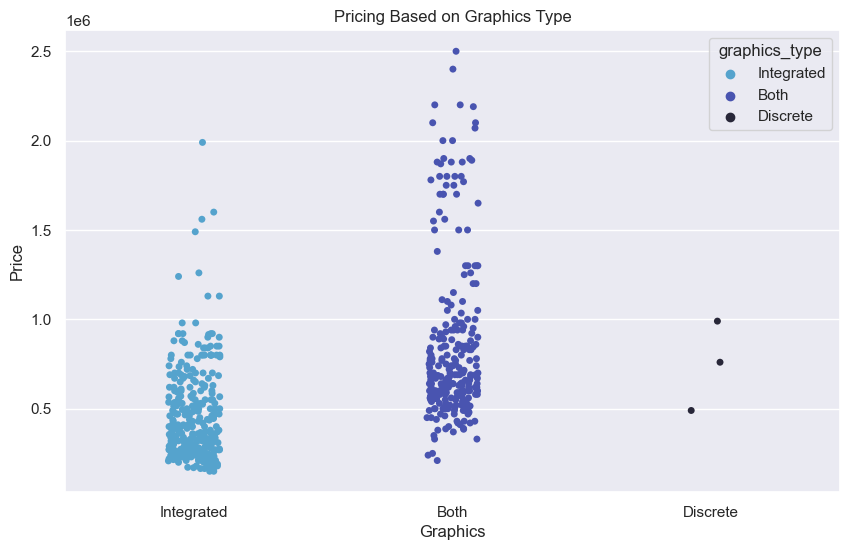

In [58]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.set_palette("icefire")

sns.stripplot(data=df_cleansed, x="graphics_type", y="old_price", hue="graphics_type")

plt.title("Pricing Based on Graphics Type")
plt.xlabel("Graphics")
plt.ylabel("Price")

plt.show()

**Jitter plots** make charts more clear in terms of **avoiding overfittings**, so we can easily assess relationships in both qualitative and quantitive ways:
* Generally laptops tend to use either **both** kinds of video chipsets or **only one (integrated in CPU),** as in shown graph tiny number of laptops have only one discrete videocard
* **Combination** of integrated and discrete graphics is on average more expensive than that of with only integrated graphics
* Significant **density** of integrated graphic laptops are priced lower than 500k tenge

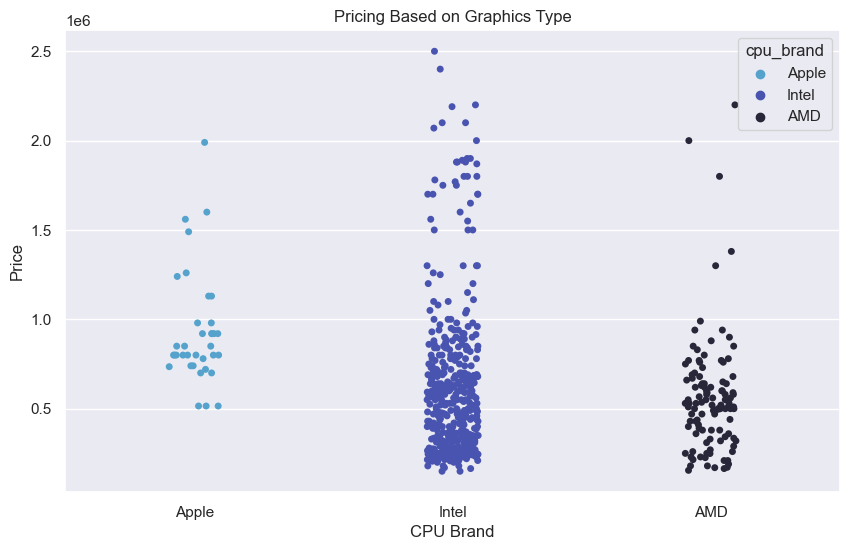

In [59]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_cleansed, x="cpu_brand", y="old_price", hue="cpu_brand")

plt.title("Pricing Based on Graphics Type")
plt.xlabel("CPU Brand")
plt.ylabel("Price")

plt.show()

In [60]:
fig = px.box(df, x="cpu_frequency", 
             y="cpu_brand", 
             color="cpu_brand")

fig.update_layout(
    width=1000,
    height=600,
    showlegend=False,
    title={
        'text': "CPU Frequency by Brand",
        'x': 0.5, 'y': 0.96,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'family': 'Arial', 'size': 20}
    }
)

fig.show()

* Intel is the most popular choice and expensive of laptop manufacturer in terms of CPU brand
* In terms of speed, AMD is better option compared with Intel chipsets (2.1 and 2.6 GHz median frequency)
As a result, **AMD** chipsets are generally better by both **speed** and **budget-friendly** perspective

In [61]:
# Function to classify GPU brands based on the GPU model a
def classify_gpu(df):
    gpu_type = df["gpu"].split()[0]
    if gpu_type in ["GeForce", "MX", "MX150", "MX250"]:
        return "NVIDIA"
    elif gpu_type == "Radeon":
        return "AMD"
    elif gpu_type == "No":
        return "Intel"
    return gpu_type

df_cleansed["gpu_brand"] = df_cleansed.apply(lambda entry: classify_gpu(entry), axis=1)
df["gpu_brand"] = df.apply(lambda entry: classify_gpu(entry), axis=1)

In [62]:
features = ["gpu_brand", "memory_type", "video_standard"]
fig = make_subplots(rows=1, cols=3, subplot_titles=["GPU Brand", "Memory Type", "Video Standard Type"])

for idx, column in enumerate(features, start=1):
    feature_means = df_cleansed.groupby(column)["old_price"].mean().sort_values()
    fig.add_trace(go.Bar(x=feature_means.index, 
                         y=feature_means.values, 
                         name=column), row=1, col=idx)
    
fig.update_layout(
    width=1450,
    height=700,
    showlegend=False,
    title={
        'text': "Mean Price by Feature",
        'x': 0.5, 'y': 0.96,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'family': 'Arial', 'size': 20}
    }
)

fig.show()

Charts show mean average prices for 3 variables (GPU, memory type, video standard)

**GPU Brand**:
* NVIDIA is positioned with the higest mean price of approximately 850k tenge (2000 USD)
* While AMD is still an affordable, yet powerful in terms of performance, for both CPU and GPU chipsets [as will be shown in next steps]
* Integrated graphics (Intel) has lowest mean prrice of 450k tg (1000 USD)

**Memory type**:
* There is a noticable difference between mean price of laptops with HDD and SSD
* Laptops with SSD stands out with significant domination of price with mean value of 650k tg (1500 USD)
* While HDD is not so popular, but budget-friendly, option with mean price three times less than laptops with SSD

In [63]:
# Fastest Laptops in Terms of CPU Frequency
targets = ["brand", "integrated_graphics", "gpu_brand", "gpu", "cpu_brand", "cpu_model", "cpu_frequency", "ram", "memory_type", "resolution"]
honored_ones = df.iloc[df["cpu_frequency"].nlargest(15).index]
honored_ones[targets]

,brand,integrated_graphics,gpu_brand,gpu,cpu_brand,cpu_model,cpu_frequency,ram,memory_type,resolution
11,Lenovo,AMD Radeon 760M,Intel,No,AMD,Ryzen 5,4.3,16,SSD,1920 x 1200
18,Lenovo,AMD Radeon 760M,Intel,No,AMD,Ryzen 5,4.3,16,SSD,1920 x 1200
116,Lenovo,AMD Radeon 760M,NVIDIA,GeForce RTX 4050,AMD,Ryzen 5,4.3,16,SSD,1920 x 1080
321,Lenovo,AMD Radeon 760M,NVIDIA,GeForce RTX 4060,AMD,Ryzen 5,4.3,16,SSD,2560 x 1440
170,ASUS,AMD Radeon 780M,Intel,No,AMD,Ryzen 9,4.0,16,SSD,1920 x 1200
411,ASUS,AMD Radeon 780M,NVIDIA,GeForce RTX 4050,AMD,Ryzen 9,4.0,16,SSD,1920 x 1080
442,ASUS,AMD Radeon 780M,NVIDIA,GeForce RTX 4070,AMD,Ryzen 9,4.0,16,SSD,2560 x 1440
22,Lenovo,AMD Radeon 780M,NVIDIA,GeForce RTX 3050,AMD,Ryzen 7,3.8,16,SSD,3072 x 1920
24,Lenovo,AMD Radeon 780M,Intel,No,AMD,Ryzen 7,3.8,16,SSD,3072 x 1920
36,Lenovo,AMD Radeon 760M,NVIDIA,GeForce RTX 4050,AMD,Ryzen 7,3.8,16,SSD,1920 x 1080


* **AMD** is the most **affordable** and **better** option in terms of **frequency** (speed indicator)
* Top 15 laptops in terms of CPU frequency are equipped with **AMD Ryzen processors******
* Lenovo, ASUS are two **fastest laptop brands** showing that they both focus on gaming laptop manufacturer
* **Well-equipped** laptops tend to have **SSD** instead of HDD

In [64]:
# Slowest Laptops in Terms of CPU Frequency
weakest_ones = df.iloc[df["cpu_frequency"].nsmallest(15).index]
weakest_ones[targets]

,brand,integrated_graphics,gpu_brand,gpu,cpu_brand,cpu_model,cpu_frequency,ram,memory_type,resolution
153,HP,Intel UHD Graphics,Intel,No,Intel,,0.8,8,SSD,1920 x 1080
219,Acer,Intel UHD Graphics,Intel,No,Intel,Core i5,1.0,4,HDD,1920 x 1080
277,Acer,Intel UHD Graphics,Intel,No,Intel,Core i5,1.0,4,HDD,1920 x 1080
303,Acer,Intel UHD Graphics,Intel,No,Intel,Core i5,1.0,4,HDD,1920 x 1080
365,ASUS,Intel UHD Graphics,Intel,No,Intel,,1.0,8,SSD,1920 x 1080
811,DELL,Intel Iris Xe Graphics,Intel,No,Intel,Core i5,1.0,8,SSD,1920 x 1200
812,DELL,Intel Iris Xe Graphics,Intel,No,Intel,Core i5,1.0,8,SSD,1920 x 1200
970,HP,Intel UHD Graphics,NVIDIA,GeForce MX330,Intel,Core i5,1.0,8,SHDD,3840 x 2160
1015,Acer,Intel UHD Graphics,Intel,No,Intel,Core i5,1.0,4,SSD,1920 x 1080
1016,Acer,Intel UHD Graphics,Intel,No,Intel,Core i5,1.0,8,SSD,1920 x 1080


In [65]:
# Most popular combination of CPU + GPU in laptops
df["cpu_gpu_combination"] = df["cpu_brand"] + " + " + df["gpu_brand"]
combinations = df["cpu_gpu_combination"].value_counts().sort_values(ascending=True)

fig = px.bar(combinations, x=combinations.values, y=combinations.index, color=combinations.index)

fig.update_layout(
    title={
        'text': "Most Popular CPU - GPU Combinations",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,
    height=600,
    xaxis_title="Count",
    yaxis_title="Combination Type",
    showlegend=False
)

fig.show()

* Intel-intel stands as the **most popular option** [933] of cpu gpu combination indicating huge number of non gaming laptops on KZ market
* Intel-NVIDIA follows next with 744 laptop offerings on KZ market
* Based on the previous exploration, all gaming laptops are equipped with NVIDIA GPU, so the cumulative sum of number of **gaming laptops** is ~950 [40%] addressing the bigger **preference** towards **non gaming laptops**

In [66]:
# Their Price Distribution
combination_prices = df.groupby("cpu_gpu_combination")["old_price"].mean().sort_values()

fig = px.bar(combination_prices, x=combination_prices.index, y=combination_prices.values, color=combination_prices.index, text_auto=True)
fig.update_layout(
    title={
        'text': "Mean Price of CPU - GPU Combinations",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1200,
    height=600,
    xaxis_title="Combination Type",
    yaxis_title="Price",
    showlegend=False
)
fig.show()


* Apple-Intel (**Macbook**) combination stands out as the combination with the highest mean price, approximately 932k tenge (>2000 USD), which indicates a significant premium compared to other combinations.
* **Gaming laptops** (NVIDIA GPU) immediately go after with mean price of 800k tenge (>1900 USD)
* Assuming that not containing NVIDIA and/or AMD video chipset is property of common laptops (**ultrabooks**), they are positioned as the cheapset option with mean price of 400k tenge (~1000 USD) 

In [67]:
combination_weights = df.groupby("cpu_gpu_combination")["weight"].mean().sort_values()
fig = px.bar(combination_weights, x=combination_weights.index, y=combination_weights.values, color=combination_weights.index, text_auto=True)
fig.update_layout(
    title={
        'text': "Weight Distribution CPU - GPU Combinations",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1200,
    height=600,
    xaxis_title="Combination Type",
    yaxis_title="Weight, kg",
    showlegend=False
)
fig.show()

* **Gaming** laptops are the **heaviest** (>2.2 kg) due to the inner properties such as extra physical videochipset, metal case, etc.
* **Macbooks** provide comfort in term of **flexibility** with slight weight of 1.5 kg

In [68]:
# Final step correlation analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   laptop_id              2368 non-null   object 
 1   brand                  2368 non-null   object 
 2   model                  2368 non-null   object 
 3   old_price              587 non-null    float64
 4   current_price          587 non-null    float64
 5   discount_rate_percent  587 non-null    float64
 6   operational_system     2368 non-null   object 
 7   graphics_type          2368 non-null   object 
 8   integrated_graphics    2368 non-null   object 
 9   gpu                    2368 non-null   object 
 10  cpu_brand              2368 non-null   object 
 11  cpu_model              2368 non-null   object 
 12  cpu_frequency          2368 non-null   float64
 13  ram                    2368 non-null   int64  
 14  memory_type            2368 non-null   object 
 15  hdd_

In [69]:
df_copy = df.copy()

In [70]:
def correlation_analysis(df_copy):
    """
    Perform correlation analysis on a laptop dataset.

    Preprocesses DataFrame to make it suitable for correlation analysis using pd.get_dummies to one-hot encode all categorical variables
    Parameters:
    df_copy (pd.DataFrame): The input DataFrame containing laptop data.

    Returns:
    pd.DataFrame: A DataFrame containing the top 10 absolute correlations with 'old_price'.
    """

    # Remove rows with missing 'old_price'
    df_copy = df_copy[df_copy["old_price"].notna()]

    # Drop non-relevant columns
    df_copy.drop(["laptop_id", "model", "cpu_model", "current_price"], axis=1, inplace=True)
    df_copy.drop(['graphics_type', 'video_standard'], axis=1, inplace=True)

    # One-hot encode the 'brand' column
    df_copy = df_copy.join(pd.get_dummies(df_copy["brand"]))
    df_copy.drop("brand", axis=1, inplace=True)

    # Extract width and height from the 'resolution' column
    df_copy["width"] = df_copy["resolution"].str.split().apply(lambda reso: int(reso[0]))
    df_copy["height"] = df_copy["resolution"].str.split().apply(lambda reso: int(reso[-1]))
    df_copy.drop("resolution", axis=1, inplace=True)

    # One-hot encode the 'memory_type' column
    df_copy = df_copy.join(pd.get_dummies(df_copy["memory_type"]))
    df_copy.drop("memory_type", axis=1, inplace=True)

    # Extract operational system categories
    df_copy["ops"] = df_copy["operational_system"].str.split().apply(lambda x: x[0])
    ops_categories = pd.get_dummies(df_copy["ops"])
    ops_categories.columns = [col + "_OS" for col in ops_categories.columns]
    df_copy = df_copy.join(ops_categories)
    df_copy.drop(["operational_system", "ops"], axis=1, inplace=True)

    # Classify GPUs and one-hot encode GPU and CPU brands
    df_copy["gpu_brand"] = df_copy.apply(lambda entry: classify_gpu(entry), axis=1)
    cpu_brands = pd.get_dummies(df_copy["cpu_brand"])
    cpu_brands.columns = [col + "_CPU" for col in cpu_brands.columns]
    df_copy = df_copy.join(cpu_brands)
    df_copy.drop("cpu_brand", axis=1, inplace=True)

    gpu_brands = pd.get_dummies(df_copy["gpu_brand"])
    gpu_brands.columns = [col + "_GPU" for col in gpu_brands.columns]
    df_copy = df_copy.join(gpu_brands)
    df_copy.drop(["gpu_brand", "integrated_graphics", "gpu"], axis=1, inplace=True)

    # One-hot encode the 'cpu_gpu_combination' column
    combination = pd.get_dummies(df_copy["cpu_gpu_combination"])
    combination.columns = [col + "_combination" for col in combination.columns]
    df_copy = df_copy.join(combination)
    df_copy.drop("cpu_gpu_combination", axis=1, inplace=True)

    # Convert boolean columns to integers
    convert_columns = df_copy.select_dtypes(include=["bool"]).columns.tolist()
    df_copy[convert_columns] = df_copy[convert_columns].astype(np.int64)

    # Calculate the correlation with 'old_price' and return the top 10
    target_correlation = df_copy.corr()["old_price"].apply(abs).sort_values(ascending=False)
    target_corr = target_correlation[target_correlation.notna()].head(11).to_frame()
    
    return target_corr.drop("old_price")

    
correlation_analysis(df_copy)

,old_price
ssd_capacity,0.755783
ram,0.723501
height,0.677842
width,0.662639
NVIDIA_GPU,0.485058
Intel_GPU,0.483527
Intel + Intel_combination,0.461047
Intel + NVIDIA_combination,0.452906
weight,0.392437
cpu_frequency,0.249536


**Top 10 factors affect price value were estimated:**
* Strong correlation is among (>0.5):

SSD, RAM capacity, screen resolution properties
* Moderate correlation is among (<=0.5):

variable indicating that either NVIDIA or Intel is main GPU, Intel-intel and intel-nvidia cpu-gpu combinations, weight

##### Finally, we can make following conclusions:
* The most expensive brand is Apple, while the most popular brand is HP
* On average, gaming laptops are considerably higher in price than ordinary laptops due to the premium component
* The higher video standards, the higher price of laptops with the most expensive on UltraHD 4k+
* Basically, AMD is the best both GPU and CPU option from cost-performance perspective
* SSD and RAM configurations strongly affect price of a laptop with the highest Pearson correlation coefficient (~0.75)
* Operating system has no notable impact  on the laptop price, moreover, the picture becomes unclear, when DOS laptops cost higher than those of with OS
* Most laptops are equipped with NVIDIA with higher price, while mostly laptops use integrated graphics.